In [1]:
import os
import time
import lime
import optuna

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from lime import lime_tabular
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
def create_dir(directory):
    if not os.path.isdir(directory):
        _path = os.path.abspath(directory).split('/')
        for i in range(1, len(_path) + 1):
            current_dir = "/".join(_path[:i])
            if not os.path.isdir(current_dir):
                os.mkdir(current_dir)


def objective(trial, X_train, y_train):
    x, y = X_train, y_train

    classifier_name = trial.suggest_categorical("classifier", 
                                                ["knn", "RandomForest",
                                                'SGDClassifier'])
    if classifier_name == "knn":
        n_neighbors = trial.suggest_int("n_neighbors", 1, 40)
        classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    elif classifier_name == 'RandomForest':
        rf_max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
        n_trees = trial.suggest_int("n_estimators", 20, 100, log=True)
        classifier_obj = RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=n_trees
        )
    elif classifier_name == 'SGDClassifier':
        alpha = trial.suggest_float('alpha', 0.0001, 0.01, log=True)
        classifier_obj = SGDClassifier(alpha=alpha)

    score = cross_val_score(classifier_obj, x.values, y.values, n_jobs=-1, cv=10)
    accuracy = score.mean()
    return accuracy

def fit_best_model(X_train, y_train, n_trials):
    # 3. Create a study object and optimize the objective function.
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler())
    study.optimize(lambda trial: objective(trial, X_train=X_train, y_train=y_train), 
                   n_trials=n_trials)
    best = study.best_params
    if best['classifier'] == "knn":
        mod = KNeighborsClassifier(n_neighbors = best['n_neighbors'])
    elif best['classifier'] == 'RandomForest':
        mod = RandomForestClassifier(
            max_depth=best['max_depth'], n_estimators=best["n_estimators"])
    elif best['classifier'] == 'LogisticRegression':
        mod = LogisticRegression(penalty=best['penalty'])
    elif best['classifier'] == 'SGDClassifier':
        mod = SGDClassifier(alpha=best['alpha'])
    
    mod.fit(X_train, y_train)
    return mod


def partial_importance_plot(model, X_train, features, title='Partial dependence plot', save=False, directory=None, 
                            filename=None):
    print("Computing partial dependence plots...")
    tic = time.time()
    _, ax = plt.subplots(figsize=(12, 8))
    display = PartialDependenceDisplay.from_estimator(
        model,
        X_train,
        features,
        kind="average",
        n_jobs=-1,
        grid_resolution=20,
        ax=ax,
    )
    print(f"done in {time.time() - tic:.3f}s")
    display.figure_.suptitle(title)
    display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)
    if save:
        create_dir(directory)
        plot.savefig(os.path.join(directory, filename))
        

In [3]:
df = pd.read_excel('../data/credit_scoring.xls', header=1)
del df['ID']

# Create data in which there is a bit small percentage of man that paid (wants to have biased data)

In [4]:
df2 = df.copy()
idx_to_out = df2[(df2['SEX']==1)&(df2['default payment next month']==0)].sample(frac=0.5).index

**before**

In [5]:
pd.crosstab(df['SEX'], df['default payment next month'])

default payment next month,0,1
SEX,,
1,9015,2873
2,14349,3763


In [6]:
df_biased = df2.loc[~df2.index.isin(idx_to_out)]

**after**

In [7]:
pd.crosstab(df_biased['SEX'], df_biased['default payment next month'])

default payment next month,0,1
SEX,,
1,4507,2873
2,14349,3763


# create the best possible model based on that data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:,:-1], df[df.columns[-1]], test_size=0.33, random_state=0)

In [9]:
X_train_biased, X_test_biased, y_train_biased, y_test_biased = train_test_split(
    df_biased.iloc[:,:-1], df_biased[df_biased.columns[-1]], test_size=0.33, random_state=0)

In [10]:
mod = fit_best_model(X_train, y_train, n_trials=30)

[I 2021-11-16 22:29:52,057] A new study created in memory with name: no-name-ab9bdc81-2e7b-4517-b104-0a2dbd1b146b
[I 2021-11-16 22:29:54,067] Trial 0 finished with value: 0.8077114427860697 and parameters: {'classifier': 'RandomForest', 'max_depth': 3, 'n_estimators': 27}. Best is trial 0 with value: 0.8077114427860697.
[I 2021-11-16 22:29:55,789] Trial 1 finished with value: 0.698407960199005 and parameters: {'classifier': 'SGDClassifier', 'alpha': 0.0034839828093783747}. Best is trial 0 with value: 0.8077114427860697.
[I 2021-11-16 22:30:03,001] Trial 2 finished with value: 0.8107960199004977 and parameters: {'classifier': 'RandomForest', 'max_depth': 23, 'n_estimators': 63}. Best is trial 2 with value: 0.8107960199004977.
[I 2021-11-16 22:30:11,087] Trial 3 finished with value: 0.8113432835820895 and parameters: {'classifier': 'RandomForest', 'max_depth': 29, 'n_estimators': 73}. Best is trial 3 with value: 0.8113432835820895.
[I 2021-11-16 22:30:14,440] Trial 4 finished with value:

In [11]:
mod_biased = fit_best_model(X_train_biased, y_train_biased, n_trials=30)

[I 2021-11-16 22:31:26,266] A new study created in memory with name: no-name-59c3e4dd-a6c7-4d75-85e1-e494878d0405
[I 2021-11-16 22:31:28,734] Trial 0 finished with value: 0.741788255824961 and parameters: {'classifier': 'knn', 'n_neighbors': 29}. Best is trial 0 with value: 0.741788255824961.
[I 2021-11-16 22:31:31,245] Trial 1 finished with value: 0.7370457298710779 and parameters: {'classifier': 'knn', 'n_neighbors': 12}. Best is trial 0 with value: 0.741788255824961.
[I 2021-11-16 22:31:33,057] Trial 2 finished with value: 0.8012764632200513 and parameters: {'classifier': 'RandomForest', 'max_depth': 11, 'n_estimators': 21}. Best is trial 2 with value: 0.8012764632200513.
[I 2021-11-16 22:31:34,479] Trial 3 finished with value: 0.6892705542270497 and parameters: {'classifier': 'SGDClassifier', 'alpha': 0.0009664313208057083}. Best is trial 2 with value: 0.8012764632200513.
[I 2021-11-16 22:31:43,188] Trial 4 finished with value: 0.8023302244923437 and parameters: {'classifier': 'Ran

In [12]:
y_fitted = mod.predict(X_train)
y_pred = mod.predict(X_test)

y_fitted_biased = mod.predict(X_train_biased)
y_pred_biased = mod.predict(X_test_biased)

In [13]:
print('-'*30, 'train', '-'*30)
print(classification_report(y_train, y_fitted))
print('-'*30, 'test', '-'*30)
print(classification_report(y_test, y_pred))


------------------------------ train ------------------------------
              precision    recall  f1-score   support

           0       0.87      0.98      0.92     15599
           1       0.88      0.47      0.61      4501

    accuracy                           0.87     20100
   macro avg       0.87      0.73      0.77     20100
weighted avg       0.87      0.87      0.85     20100

------------------------------ test ------------------------------
              precision    recall  f1-score   support

           0       0.84      0.95      0.90      7765
           1       0.68      0.36      0.47      2135

    accuracy                           0.83      9900
   macro avg       0.76      0.66      0.68      9900
weighted avg       0.81      0.83      0.80      9900



In [14]:
print('-'*30, 'train', '-'*30)
print(classification_report(y_train_biased, y_fitted_biased))
print('-'*30, 'test', '-'*30)
print(classification_report(y_test_biased, y_pred_biased))


------------------------------ train ------------------------------
              precision    recall  f1-score   support

           0       0.83      0.97      0.90     12654
           1       0.84      0.43      0.57      4425

    accuracy                           0.83     17079
   macro avg       0.84      0.70      0.73     17079
weighted avg       0.83      0.83      0.81     17079

------------------------------ test ------------------------------
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      6202
           1       0.85      0.44      0.58      2211

    accuracy                           0.83      8413
   macro avg       0.84      0.71      0.74      8413
weighted avg       0.83      0.83      0.81      8413



Similar accuracy can suggest that models work similarly but following analysis shows that they differ a lot. In features importance analysis we can see that biased one often use sex as one of most important variables. 

Obviously, possibility to pay for bills can't depend on our sex

# LIME

In [15]:
X_train_categorical = [1,2,3,5,6,7,8,9,10]
explainer = lime_tabular.LimeTabularExplainer(X_train.values, mode="classification", 
                                              training_labels= y_train,
                                              feature_names= X_train.columns, 
                                             categorical_features=X_train_categorical,
                                             class_names=['pay on time', 'default'])

In [16]:
explainer_biased = lime_tabular.LimeTabularExplainer(X_train_biased.values, mode="classification", 
                                              training_labels= y_train_biased,
                                              feature_names= X_train_biased.columns, 
                                             categorical_features=X_train_categorical,
                                             class_names=['pay on time', 'default'])

### Plot local importance

In [41]:
ids_for_tests = X_test.index.intersection(X_test_biased.index)

/home/sigmo42/anaconda3/envs/summarizer/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Prediction :  0
Actual :      0


/home/sigmo42/anaconda3/envs/summarizer/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/sigmo42/anaconda3/envs/summarizer/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Prediction :  0
Actual :      0


/home/sigmo42/anaconda3/envs/summarizer/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


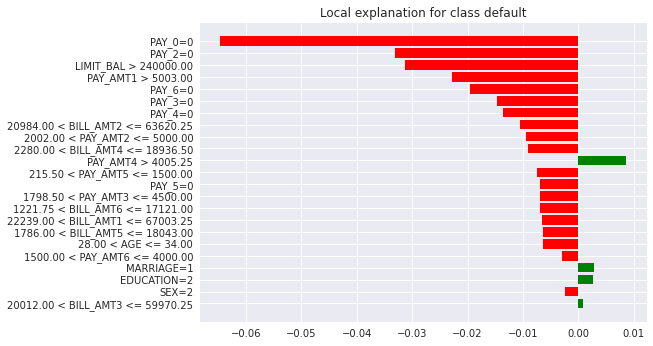

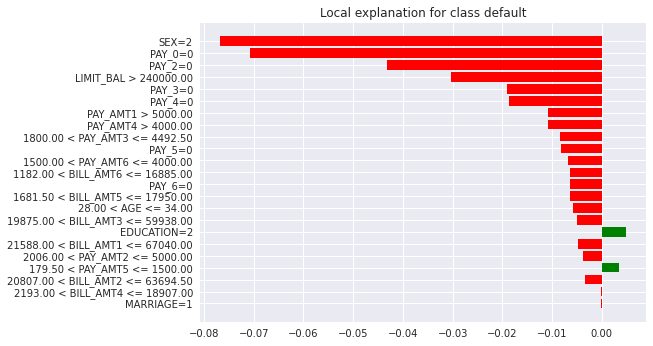

In [43]:
# define same idx to compare results from based and unbased
idx = np.random.choice(ids_for_tests)
print("Prediction : ", mod.predict(X_test.loc[idx].values.reshape(1,-1))[0])
print("Actual :     ", y_test.loc[idx])
explanation = explainer.explain_instance(X_test.loc[idx].values, mod.predict_proba, 
                                         num_features=X_train.columns.shape[0])
with plt.style.context("seaborn"):
    explanation.as_pyplot_figure()
    
    
print("Prediction : ", mod_biased.predict(X_test_biased.loc[idx].values.reshape(1,-1))[0])
print("Actual :     ", y_test_biased.loc[idx])
explanation_biased = explainer_biased.explain_instance(X_test_biased.loc[idx].values, mod_biased.predict_proba, 
                                         num_features=X_train_biased.columns.shape[0])
with plt.style.context("seaborn"):
    explanation_biased.as_pyplot_figure()    

# Global importance

### Permutation Importance on train

In [20]:
result = permutation_importance(mod, X_train, y_train, n_repeats=10, random_state=0)
sorted(list(zip(X_train.columns, result.importances_mean)), key=lambda x: x[1], reverse=True)

[('PAY_0', 0.07300497512437808),
 ('PAY_2', 0.018671641791044736),
 ('PAY_AMT1', 0.011990049751243759),
 ('LIMIT_BAL', 0.011243781094527339),
 ('PAY_AMT2', 0.011129353233830807),
 ('PAY_AMT6', 0.009288557213930316),
 ('PAY_4', 0.008736318407960176),
 ('AGE', 0.008696517412935279),
 ('PAY_3', 0.00854726368159201),
 ('PAY_5', 0.00821393034825867),
 ('PAY_6', 0.00754726368159202),
 ('BILL_AMT1', 0.007442786069651719),
 ('PAY_AMT5', 0.007432835820895512),
 ('BILL_AMT4', 0.00735323383084574),
 ('PAY_AMT3', 0.006900497512437753),
 ('BILL_AMT2', 0.006890547263681568),
 ('BILL_AMT3', 0.006363184079601947),
 ('PAY_AMT4', 0.006059701492537284),
 ('BILL_AMT5', 0.0056318407960198715),
 ('BILL_AMT6', 0.00530845771144276),
 ('EDUCATION', 0.0037562189054726304),
 ('MARRIAGE', 0.002099502487562166),
 ('SEX', 0.001442786069651736)]

In [21]:
result_biased = permutation_importance(mod_biased, X_train_biased, y_train_biased, n_repeats=10, random_state=0)
sorted(list(zip(X_train_biased.columns, result_biased.importances_mean)), key=lambda x: x[1], reverse=True)

[('PAY_0', 0.08031500673341535),
 ('SEX', 0.014462205047133936),
 ('PAY_2', 0.014386088178464828),
 ('BILL_AMT1', 0.008009836641489621),
 ('PAY_AMT2', 0.007313074535979913),
 ('PAY_AMT1', 0.007231102523567001),
 ('LIMIT_BAL', 0.007125709936178981),
 ('PAY_3', 0.007090579073716319),
 ('PAY_AMT3', 0.006727560161602031),
 ('PAY_AMT4', 0.00643480297441309),
 ('PAY_4', 0.006382106680719058),
 ('PAY_5', 0.006194742080918148),
 ('PAY_AMT6', 0.0059136951812167275),
 ('PAY_AMT5', 0.005814157737572512),
 ('BILL_AMT5', 0.0055038351191522335),
 ('BILL_AMT4', 0.005240353650682183),
 ('BILL_AMT2', 0.005099830200831501),
 ('BILL_AMT3', 0.0049534516072370135),
 ('AGE', 0.004812928157386332),
 ('PAY_6', 0.0045670121201476285),
 ('BILL_AMT6', 0.003911236020844355),
 ('EDUCATION', 0.0020551554540664263),
 ('MARRIAGE', 0.0009778090052111165)]

### Permutation Importance on test

In [22]:
result = permutation_importance(mod, X_test, y_test, n_repeats=10, random_state=0)
sorted(list(zip(X_train.columns, result.importances_mean.round(4))), key=lambda x: x[1], reverse=True)

[('PAY_0', 0.0592),
 ('PAY_2', 0.0023),
 ('BILL_AMT2', 0.0023),
 ('BILL_AMT6', 0.0021),
 ('PAY_AMT2', 0.0018),
 ('PAY_AMT3', 0.0016),
 ('PAY_3', 0.0011),
 ('PAY_AMT5', 0.0009),
 ('BILL_AMT5', 0.0008),
 ('PAY_4', 0.0007),
 ('BILL_AMT3', 0.0006),
 ('SEX', 0.0005),
 ('PAY_5', 0.0005),
 ('PAY_AMT6', 0.0005),
 ('BILL_AMT1', 0.0003),
 ('PAY_AMT1', 0.0003),
 ('PAY_AMT4', 0.0003),
 ('LIMIT_BAL', 0.0002),
 ('MARRIAGE', 0.0002),
 ('EDUCATION', 0.0001),
 ('BILL_AMT4', 0.0001),
 ('AGE', -0.0001),
 ('PAY_6', -0.0006)]

In [23]:
result_biased = permutation_importance(mod_biased, X_test_biased, y_test_biased, n_repeats=10, random_state=0)
sorted(list(zip(X_train_biased.columns, result_biased.importances_mean)), key=lambda x: x[1], reverse=True)

[('PAY_0', 0.0742422441459645),
 ('SEX', 0.004100796386544592),
 ('BILL_AMT1', 0.0019731368120764923),
 ('PAY_AMT3', 0.0012837275644834833),
 ('PAY_2', 0.0012005230001188249),
 ('BILL_AMT5', 0.0012005230001188138),
 ('PAY_AMT2', 0.0009746820397004141),
 ('PAY_AMT5', 0.0009509093070247832),
 ('PAY_6', 0.0008677047426601248),
 ('BILL_AMT2', 0.0007726138119576231),
 ('PAY_AMT6', 0.0006656365149173449),
 ('PAY_AMT1', 0.000653750148579535),
 ('AGE', 0.0004397955544989451),
 ('BILL_AMT4', 0.0002496136930939641),
 ('BILL_AMT3', 0.00023772732675616525),
 ('LIMIT_BAL', 0.00020206822774274658),
 ('PAY_AMT4', 0.00015452276239148467),
 ('EDUCATION', 1.1886366337754417e-05),
 ('PAY_4', -0.00021395459408064533),
 ('PAY_3', -0.00040413645548562636),
 ('MARRIAGE', -0.00043979555449906725),
 ('BILL_AMT6', -0.0005467728515393344),
 ('PAY_5', -0.0010460002377273736)]

### Feature Importance from Random Forest

In [54]:
if isinstance(mod, RandomForestClassifier):
    df = pd.DataFrame(list(zip(X_train.columns, mod.feature_importances_)), columns = ['feature', 'importance'])
    print(df.sort_values('importance', ascending=False))

      feature  importance
5       PAY_0    0.215971
6       PAY_2    0.101108
17   PAY_AMT1    0.047263
8       PAY_4    0.041354
11  BILL_AMT1    0.041336
18   PAY_AMT2    0.040494
0   LIMIT_BAL    0.040480
10      PAY_6    0.040144
9       PAY_5    0.039992
12  BILL_AMT2    0.037882
7       PAY_3    0.036562
4         AGE    0.034740
14  BILL_AMT4    0.034550
15  BILL_AMT5    0.033740
13  BILL_AMT3    0.033452
16  BILL_AMT6    0.032635
22   PAY_AMT6    0.032620
21   PAY_AMT5    0.032163
19   PAY_AMT3    0.030708
20   PAY_AMT4    0.027340
2   EDUCATION    0.011921
3    MARRIAGE    0.006843
1         SEX    0.006700


In [55]:
if isinstance(mod_biased, RandomForestClassifier):
    df_biased = pd.DataFrame(list(zip(X_train_biased.columns, mod_biased.feature_importances_)), columns = ['feature', 'importance'])
    print(df_biased.sort_values('importance', ascending=False))


      feature  importance
5       PAY_0    0.247661
6       PAY_2    0.114665
7       PAY_3    0.073952
1         SEX    0.053708
8       PAY_4    0.052675
9       PAY_5    0.037528
11  BILL_AMT1    0.035860
0   LIMIT_BAL    0.035380
18   PAY_AMT2    0.031789
19   PAY_AMT3    0.030539
17   PAY_AMT1    0.030449
10      PAY_6    0.029782
12  BILL_AMT2    0.027201
13  BILL_AMT3    0.026544
4         AGE    0.023836
21   PAY_AMT5    0.023523
14  BILL_AMT4    0.023467
15  BILL_AMT5    0.023041
22   PAY_AMT6    0.022890
16  BILL_AMT6    0.022819
20   PAY_AMT4    0.022175
2   EDUCATION    0.006284
3    MARRIAGE    0.004233


### Partial plot importance

In [26]:
features = ['BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
title = "Partial dependence of billings amount features"


Computing partial dependence plots...
done in 1.973s


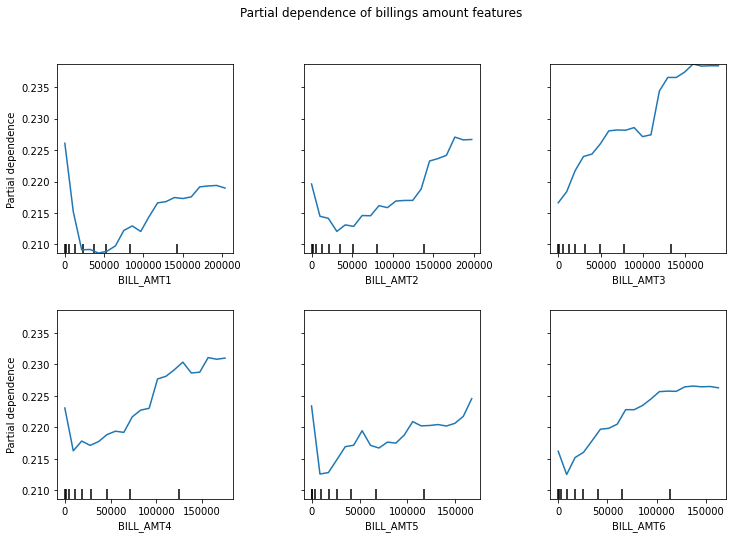

In [28]:
partial_importance_plot(mod, X_test, features, title, save=False)

Computing partial dependence plots...
done in 2.293s


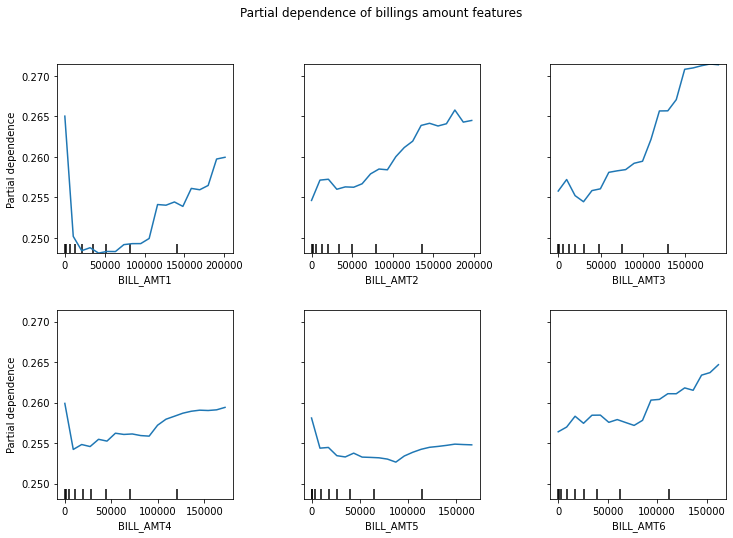

In [29]:
partial_importance_plot(mod_biased, X_test_biased, features, title, save=False)

In [30]:
features = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']
title = "Partial dependence of payment delays features"


Computing partial dependence plots...
done in 1.124s


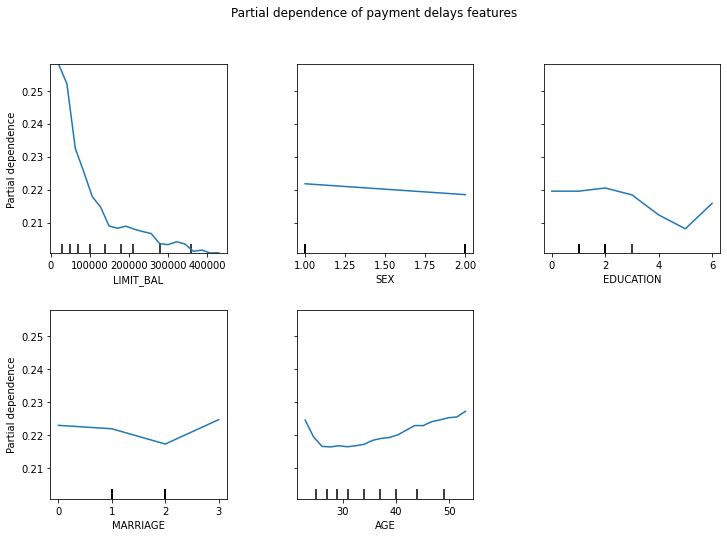

In [31]:
partial_importance_plot(mod, X_test, features, title, save=False)

Computing partial dependence plots...
done in 1.428s


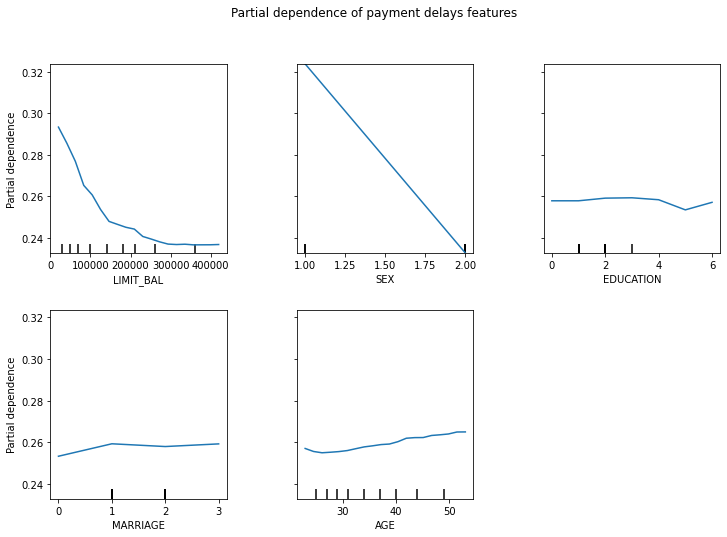

In [32]:
partial_importance_plot(mod_biased, X_test_biased, features, title, save=False)

In [33]:
features = [f'PAY_{i}' for i in range(7)]
features.pop(1)
title = "Partial dependence of billings other features"


Computing partial dependence plots...
done in 1.061s


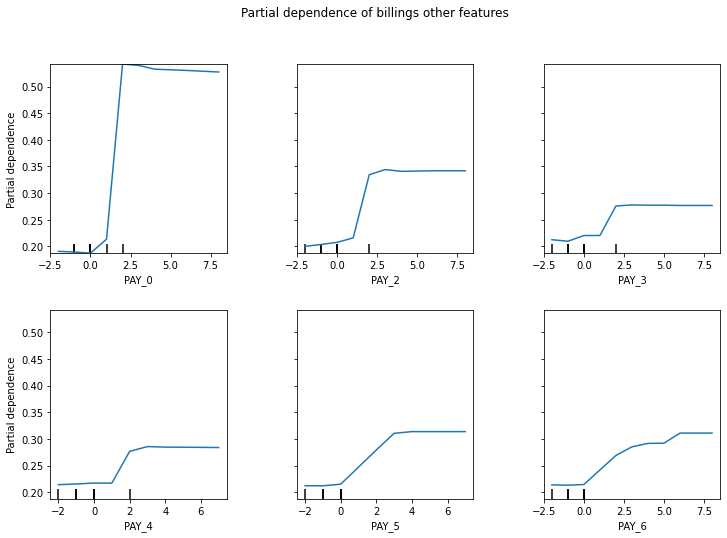

In [34]:
partial_importance_plot(mod, X_test, features, title, save=False)

Computing partial dependence plots...
done in 1.314s


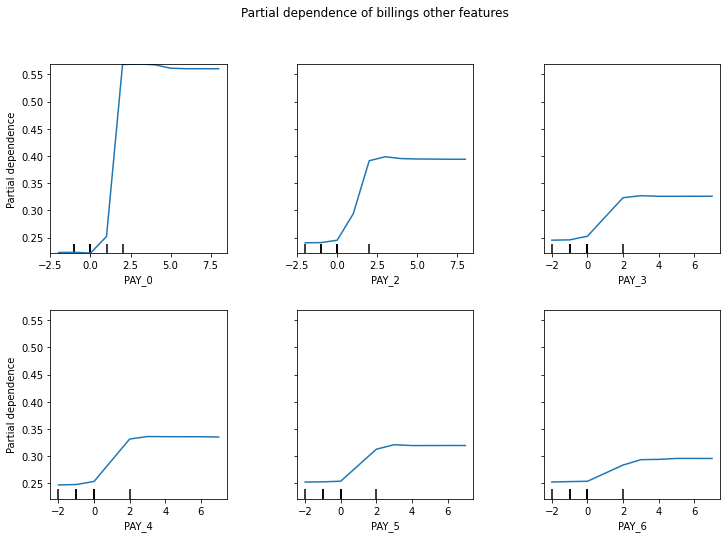

In [35]:
partial_importance_plot(mod_biased, X_test_biased, features, title, save=False)